Retaining existing customers is generally more straightforward and cost-effective than acquiring new ones, which makes having a robust churn model essential for any business. By effectively predicting which customers are likely to leave, companies can implement targeted retention strategies and interventions. This not only helps in maintaining customer loyalty but also reduces the overall cost associated with customer acquisition. A well-developed churn model empowers businesses to make informed decisions, optimizing resources and ultimately enhancing profitability.

A churn prediction model will be developed for a U.S. telecommunications company that has recently observed a significant number of customers leaving for competitors. This has resulted in both revenue losses and a decline in their market share. The company aims to take proactive commercial actions to retain their high-value customers who are at risk of churning. By leveraging predictive analytics, the goal is to identify these customers early and implement targeted retention strategies to minimize churn and protect their market position.








https://www.kaggle.com/c/customer-churn-prediction-2020/overview

## 1. Import libraries, functions and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, make_scorer, precision_score, recall_score, f1_score, make_scorer, accuracy_score, roc_curve
import joblib
import category_encoders as ce
import shap

In [40]:
def analyze_statistics(df):
    """
    Calculate and return detailed statistical information for each numerical variable in the dataset.

    This function computes various statistics for numerical columns in a DataFrame, such as mean, standard deviation, quartiles,
    outliers, percentage of missing values, and more.

    Args:
        df (pd.DataFrame): The input DataFrame containing the dataset.

    Returns:
        pd.DataFrame: A DataFrame containing statistical descriptions for each numerical column.
                      The columns include:
                      - column_name: Name of the column
                      - count: Number of non-missing values
                      - mean: Mean value
                      - std: Standard deviation
                      - min: Minimum value
                      - 25%: First quartile (25th percentile)
                      - 50%: Median (50th percentile)
                      - 75%: Third quartile (75th percentile)
                      - 99%: 99th percentile
                      - max: Maximum value
                      - missing: Percentage of missing values
                      - num_zeros: Percentage of zeros in the column
                      - num_outliers: Number of outliers based on the 1.5 * IQR rule
                      - porc_neg: Percentage of negative values
                      - porc_pos: Percentage of positive values
                      - dtype: Data type of the column
    """
    all_stats = pd.DataFrame()
    print("Statistical description for each numerical variable in the dataset: ")
    num_cols = [e for e in df.select_dtypes(include=['float64', 'int64']).columns.tolist()]
    print("There are {0} numerical features.".format(len(num_cols)))
    for col in df.columns:
        if (df[col].dtype == 'float64') | (df[col].dtype == 'int64'):
            IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
            stats = {
                'column_name': col,
                'count': df[col].count(),
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                '25%': df[col].quantile(0.25),
                '50%': df[col].median(),
                '75%': df[col].quantile(0.75),
                '99%': df[col].quantile(0.99),
                'max': df[col].max(),
                'missing': (df[col].isnull().sum()/len(df[col]))*100,
                'num_zeros': ((df[col] == 0).sum()/len(df[col]))*100,  
                'num_outliers': df[(df[col] < df[col].quantile(0.25) - 1.5 * IQR) | (df[col] > df[col].quantile(0.75) + 1.5 * IQR)][col].count(),
                'porc_neg': ((df[col] < 0).sum()/len(df[col]))*100,
                'porc_pos': ((df[col] > 0).sum()/len(df[col]))*100,
                'dtype': df[col].dtype
            }
 
            col_stats = pd.DataFrame(stats, index=[0])
            all_stats = pd.concat([all_stats, col_stats])
 
 
    return all_stats

In [41]:
def clasification_fs(X_train: pd.DataFrame, y_train: pd.DataFrame):
    """A first classification model is created using XGBoost to select the features with the highest importance in the model.

    Args:
        X_train (dataframe): training features table
        y_train (dataframe): training target variable table
    """
    modelo_classifier = xgb.XGBClassifier(
    objective='binary:logistic',     # The objective function for binary classification.
    seed=1234,                       # Seed for reproducibility.
    subsample=0.9,                   # Proportion of samples to be used for fitting the individual base learners.
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting; lower values make the model more robust.
    max_depth=4,                     # Maximum depth of a tree; controls the complexity of the model.
    min_child_weight=25,             # Minimum sum of instance weight (hessian) needed in a child; helps prevent overfitting.
    colsample_bytree=0.9,            # Proportion of features to be randomly sampled for each tree.
    max_delta_step=6,                # Maximum delta step we allow each leaf output to be; can be used for logistic regression.
    n_estimators=300,                # Number of trees (estimators) to fit.
    eval_metric='logloss'            # Evaluation metric to monitor during training.
    )
    
    # Fit the model on the training data with early stopping based on log loss
    modelo_classifier.fit(
        X_train, 
        y_train,
        verbose=False, 
    )       

    predicciones_train = modelo_classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, predicciones_train)
    print(f"Model accuracy for train: {accuracy_train:.2f}")

    conf_matrix_train = confusion_matrix(y_train, predicciones_train)
    print("Confusion Matrix for train:")
    print(conf_matrix_train)

    classification_report_train = classification_report(y_train, predicciones_train)
    print("Classification Report for train:")
    print(classification_report_train)

    importance_frequency = modelo_classifier.get_booster().get_score(importance_type='weight')
    importance_cover = modelo_classifier.get_booster().get_score(importance_type='cover')
    importance_gain = modelo_classifier.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
                                    'Feature': list(importance_frequency.keys()),
                                    'Frequency': list(importance_frequency.values()),
                                    'Gain': list(importance_gain.values())
                                    })
    total_freq = importance_df['Frequency'].sum()
    total_gain = importance_df['Gain'].sum()

    importance_df['frequency_proportion'] = importance_df['Frequency'] / total_freq
    importance_df['gain_proportion'] = importance_df['Gain'] / total_gain


    display(importance_df)
    
       
    return (modelo_classifier), importance_df



In [ ]:
def shap_to_probability_contributions(base_value, shap_values, features):
    """
    Convert SHAP values into probability contributions for each feature.

    Args:
        base_value (float): The base value (log-odds) of the model for the dataset.
        shap_values (array): SHAP values for a single observation (array of feature contributions in log-odds).
        features (list): List of feature names corresponding to the SHAP values.

    Returns:
        dict: A dictionary where keys are feature names and values are their respective probability contributions.
        float: The total probability predicted for the observation.
    """
    # Calculate the total log-odds by summing the base value and the SHAP values
    log_odds_total = base_value + np.sum(shap_values)

    # Convert log-odds to probability using the sigmoid function
    prob_total = 1 / (1 + np.exp(-log_odds_total))

    # Initialize a dictionary to store contributions of each feature to the probability
    contributions = {}

    # Loop through each feature and calculate its probability contribution
    for i, feature in enumerate(features):
        # Remove the SHAP value of the current feature from the total log-odds
        log_odds_without_feature = log_odds_total - shap_values[i]

        # Convert the new log-odds (without this feature) back to probability
        prob_without_feature = 1 / (1 + np.exp(-log_odds_without_feature))

        # Calculate the probability contribution of the current feature
        # Contribution is the difference in probability with and without the feature
        prob_contribution = prob_total - prob_without_feature
        contributions[feature] = prob_contribution

    return contributions, prob_total

In [42]:
df = pd.read_csv(r"C:\Users\alfon\OneDrive\Escritorio\CAPGEMINI\train.csv")


## 2. Dataset info

In this section, it will be provided an overview of the dataset, highlighting its structure and contents. This will include a summary of the data types, the number of observaations, and the identification of any missing values or duplicates. This analysis will help in understanding the structue of the data and its suitability for further analysis.

In [43]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [44]:
print('The number of row in the data is :', df.shape[0])
print('The number of columns in the data is :', df.shape[1])

The number of row in the data is : 4250
The number of columns in the data is : 20


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

Columns (variables) information :

Categorical data

- state = 2-letter code of the US state of customer residence. 
- area_code = Area with 3 digit code.
- international_plan (Yes,No) = The customer has international plan.
- voice_mail_plan (Yes,No) = The customer has voice mail plan.
- churn (Yes,No) = Customer churn - target variable.

Numerical data

- account_length = Number of months the customer has been with the current telco provider
- number_vmail_messages = Number of voice-mail messages. \n
- total_day_minutes = Total minutes of day calls.
- total_day_calls = Total number of day calls.
- total_day_charge = Total charge of day calls.
- total_eve_minutes = Total minutes of evening calls.
- total_eve_calls = Total number of evening calls.
- total_eve_charge = Total charge of evening calls.
- total_night_minutes = Total minutes of night calls.
- total_night_calls = Total number of night calls.
- total_night_charge = Total charge of night calls.
- total_intl_minutes = Total minutes of international calls.
- total_intl_calls = Total number of international calls.
- total_intl_charge = Total charge of international calls.
- number_customer_service_calls = Number of calls to customer service

# 3. Exploratory Data Analysis (EDA)

During the Exploratory Data Analysis (EDA) phase, we will focus on analyzing the distributions of the data and exploring how different variables relate to one another. Additionally, we will be looking for patterns in behavior that could provide insights into the dataset. This step is crucial for identifying underlying trends and potential correlations that can guide further analysis and model development.

Firstly, it will be shown essential statistical information for each numerical column in the dataset. This function calculates various metrics, including the count of non-null entries, mean, standard deviation, minimum and maximum values, and relevant percentiles. Additionally, it provides insights into the proportion of missing values, the percentage of zeros, and the presence of outliers, which are identified using the interquartile range method. 

In [46]:
analyze_statistics(df)

Statistical description for each numerical variable in the dataset: 
There are 15 numerical features.


,column_name,count,mean,std,min,25%,50%,75%,99%,max,missing,num_zeros,num_outliers,porc_neg,porc_pos,dtype
0,account_length,4250,100.236235,39.698401,1.0,73.0000,100.00,127.0000,194.0000,243.00,0.0,0.000000,20,0.0,100.000000,int64
0,number_vmail_messages,4250,7.631765,13.439882,0.0,0.0000,0.00,16.0000,43.0000,52.00,0.0,73.858824,86,0.0,26.141176,int64
0,total_day_minutes,4250,180.259600,54.012373,0.0,143.3250,180.45,216.2000,304.8550,351.50,0.0,0.047059,25,0.0,99.952941,float64
0,total_day_calls,4250,99.907294,19.850817,0.0,87.0000,100.00,113.0000,145.5100,165.00,0.0,0.047059,28,0.0,99.952941,int64
0,total_day_charge,4250,30.644682,9.182096,0.0,24.3650,30.68,36.7500,51.8259,59.76,0.0,0.047059,26,0.0,99.952941,float64
0,total_eve_minutes,4250,200.173906,50.249518,0.0,165.9250,200.70,233.7750,318.6510,359.30,0.0,0.023529,34,0.0,99.976471,float64
0,total_eve_calls,4250,100.176471,19.908591,0.0,87.0000,100.00,114.0000,147.0000,170.00,0.0,0.023529,24,0.0,99.976471,int64
0,total_eve_charge,4250,17.015012,4.271212,0.0,14.1025,17.06,19.8675,27.0851,30.54,0.0,0.023529,34,0.0,99.976471,float64
0,total_night_minutes,4250,200.527882,50.353548,0.0,167.2250,200.45,234.7000,317.5550,395.00,0.0,0.023529,37,0.0,99.976471,float64
0,total_night_calls,4250,99.839529,20.093220,0.0,86.0000,100.00,113.0000,147.5100,175.00,0.0,0.023529,33,0.0,99.976471,int64


In [47]:
df.describe(include='O')

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


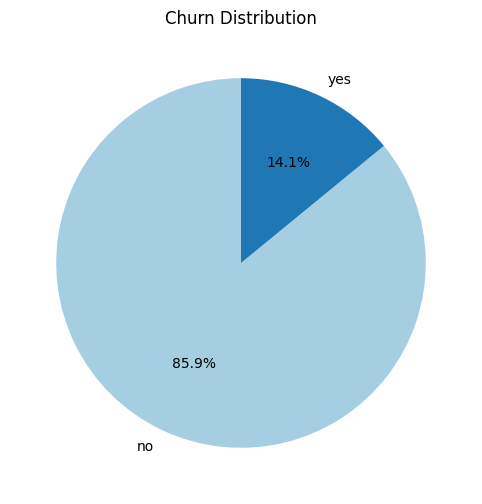

In [48]:
plt.figure(figsize=(9,6 ))
plt.pie(
    df['churn'].value_counts(), 
    labels=df['churn'].value_counts().index, 
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',  
    startangle=90,  
    colors=plt.cm.Paired.colors  
)

plt.title('Churn Distribution')
plt.show()

Based on the data, 86% of customers stay with the provider's services, while only 14% of customer churns.

We are facing a class imbalance problem, with 86% of the instances belonging to the non-churn class and only 14% to the churn class. This significant disparity can lead to biased model predictions, as algorithms may favor the majority class.
Sometimes, one useful approach is to perform under-sampling of the majority class to balance the class distribution. Additionally, techniques for generating synthetic data, such as SMOTE, can also be employed to create more instances of the minority class. But the initial intention is to maintain the original dataset

We are going to calculate the number of customers who, despite not having an international plan, are still making international calls. This analysis will help us understand customer behavior and the potential need for additional services or plans to cater to these customers, who may be incurring extra charges or might be interested in upgrading their current plans.

In [49]:
df.groupby('international_plan')[['total_intl_minutes','total_intl_calls', 'total_intl_charge']].sum()

,total_intl_minutes,total_intl_calls,total_intl_charge
international_plan,,,
no,39445.7,17038,10652.34
yes,4142.6,1774,1118.69


In [50]:
df_inter = df[df['international_plan']=='no']
df_inter[df_inter['total_intl_calls']>1].shape

(3628, 20)

Now, it will be created plots to analyze the distributions of each numerical variable using a histogram combined with a  density function. This approach will help us understand the underlying distribution patterns and identify any potential skewness or outliers in the data

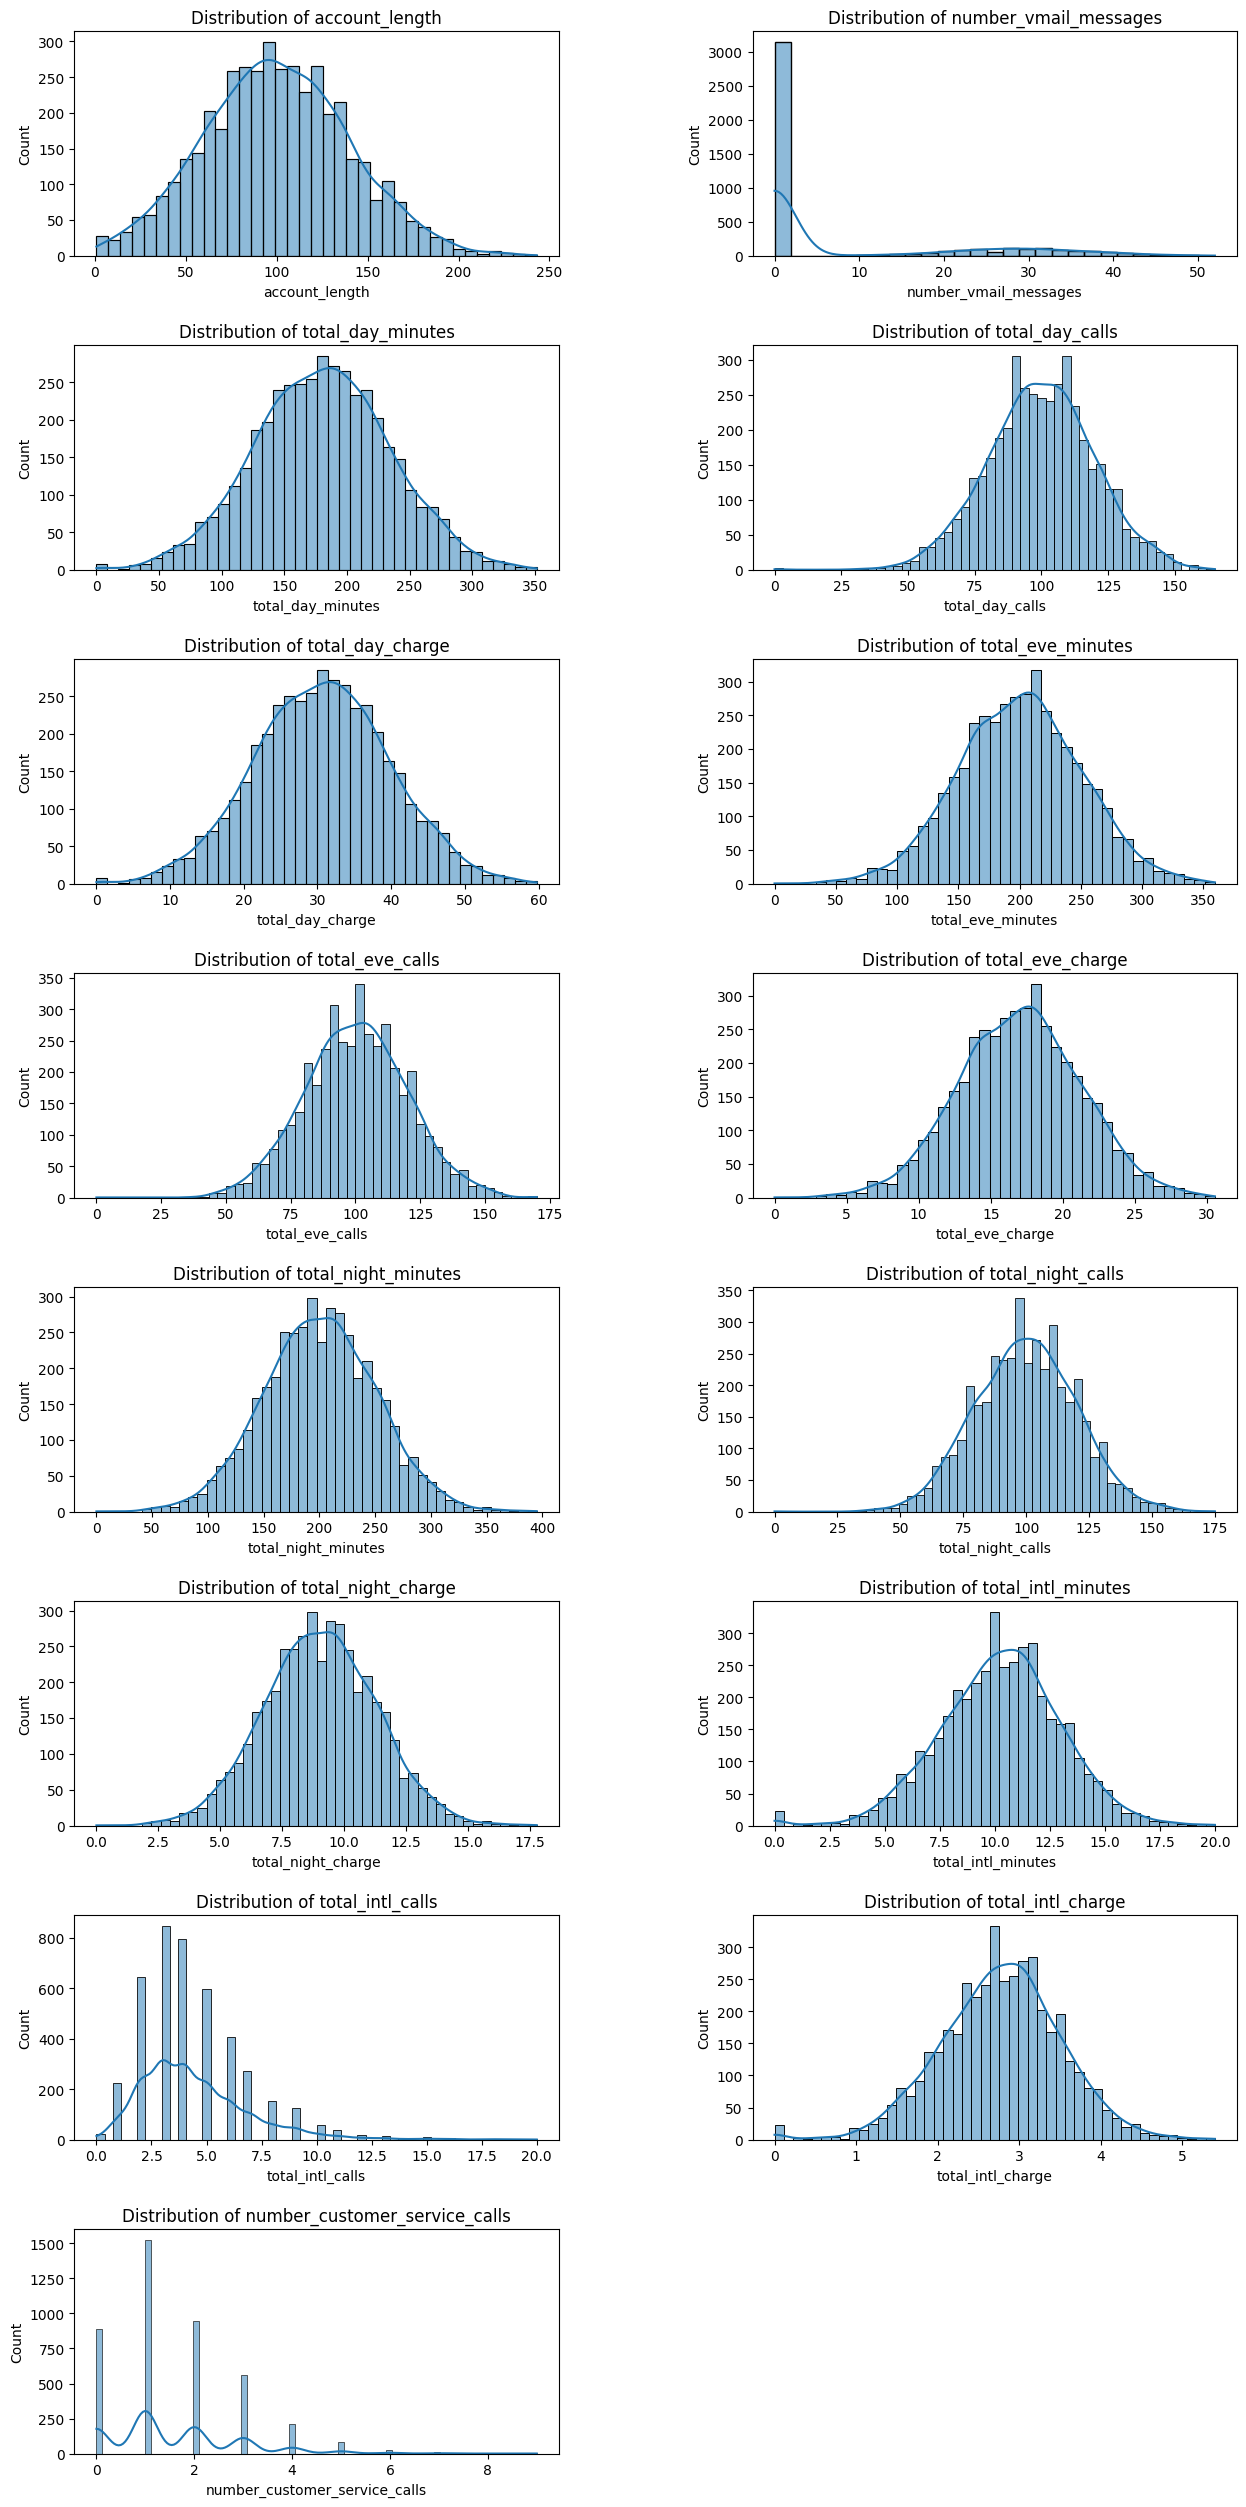

In [51]:
# Filter numeric columns
num_cols = [e for e in df.select_dtypes(include=['float64', 'int64']).columns.tolist()]

# Create the figure for the plots
fig = plt.figure(figsize=(15, len(num_cols) * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through the numeric columns and generate the plots
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(len(num_cols), 2, i + 1)
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.show()

Based on the visualization result, almost all the numerical columns  are normal distribution or the majority of the data around in mean, median, mode value except number_vmail_messages, total_intl_calls, number_customer_service_calls.



Boxplots are a powerful visualization tool that allow us to easily identify outliers within our data. By displaying the distribution of data points across different quartiles, boxplots highlight any values that fall outside the expected range, making them stand out as potential outliers. 

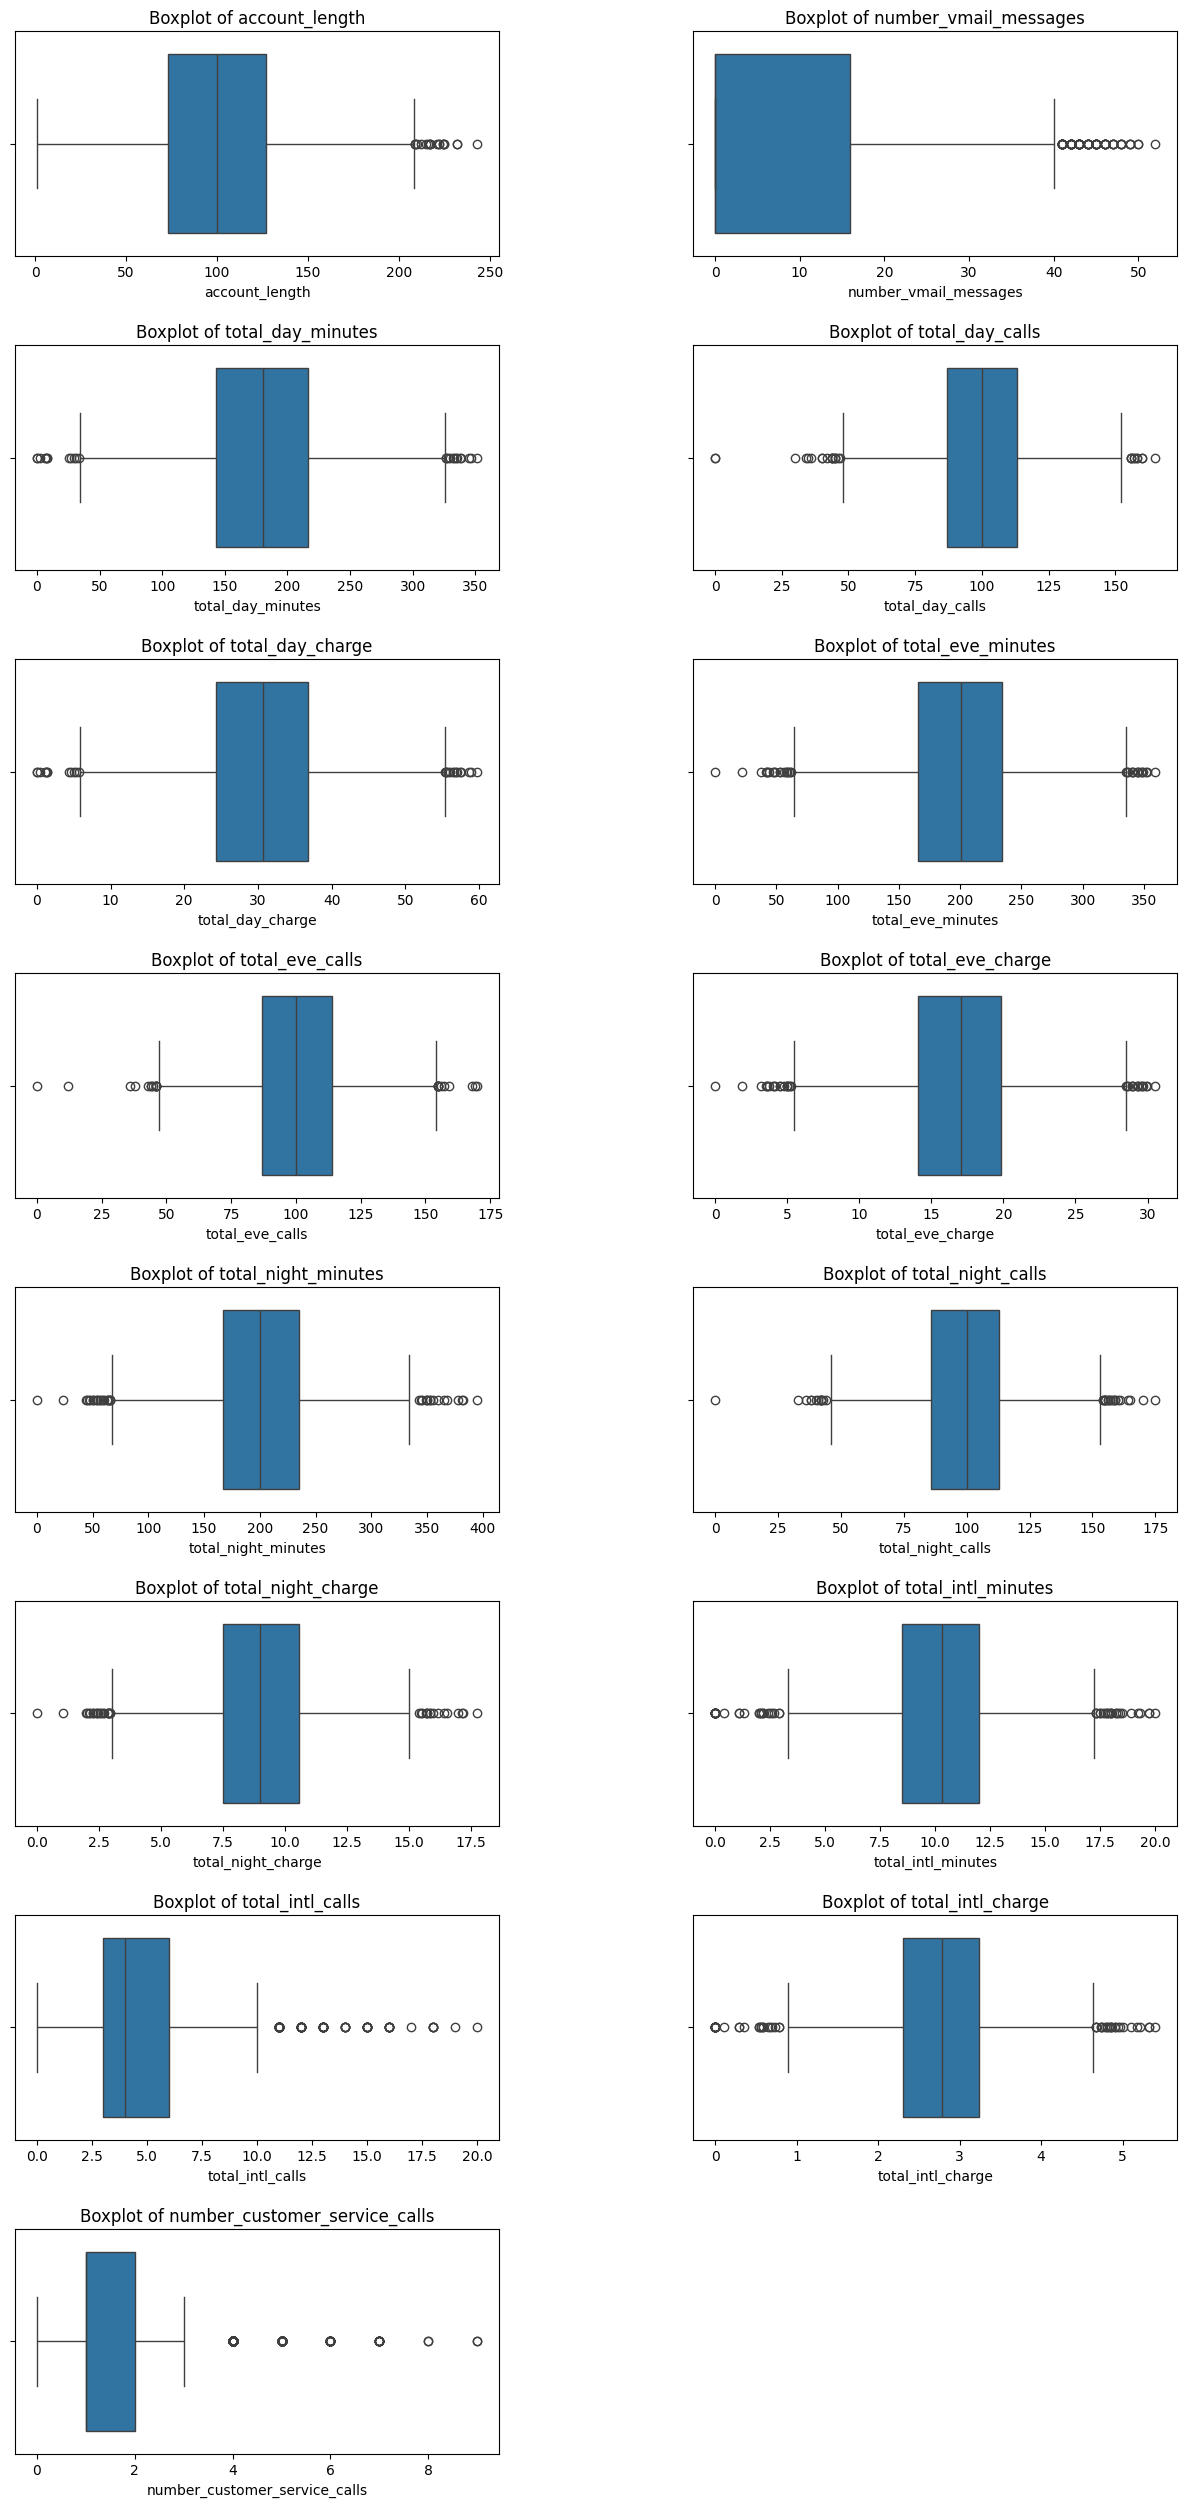

In [52]:
fig = plt.figure(figsize=(15, len(num_cols) * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(num_cols):
    ax = fig.add_subplot(len(num_cols), 2, i + 1)
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')

plt.show()

In [53]:
num_column = df.describe().columns.values
n = 0
for col in num_column:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)
    total = len(df[col][(((df[col] < low_limit)) | (df[col] > high_limit))])
    n = n + total
    print('There are {} row data outlier in columns  {}'.format(total, col))

There are 20 row data outlier in columns  account_length
There are 86 row data outlier in columns  number_vmail_messages
There are 25 row data outlier in columns  total_day_minutes
There are 28 row data outlier in columns  total_day_calls
There are 26 row data outlier in columns  total_day_charge
There are 34 row data outlier in columns  total_eve_minutes
There are 24 row data outlier in columns  total_eve_calls
There are 34 row data outlier in columns  total_eve_charge
There are 37 row data outlier in columns  total_night_minutes
There are 33 row data outlier in columns  total_night_calls
There are 37 row data outlier in columns  total_night_charge
There are 62 row data outlier in columns  total_intl_minutes
There are 100 row data outlier in columns  total_intl_calls
There are 62 row data outlier in columns  total_intl_charge
There are 335 row data outlier in columns  number_customer_service_calls


Although outliers are present in the dataset, we have decided not to remove them as they do not represent erroneous or irrelevant values. Instead, these outliers likely reflect real-life scenarios, such as unusually high numbers of calls made by certain individuals. Removing them could lead to a loss of valuable information that may be critical for understanding the variability and behavior of our data. By retaining these outliers, we ensure that our analysis captures the full range of customer behaviors.

To handle outliers, there are several techniques that can be applied depending on the context and the impact of the outliers on the analysis. One common approach is winsorization, which involves capping extreme values at a predefined percentile, such as the 1st and 99th percentiles, to reduce their influence while preserving the overall distribution. Another option is to replace outliers with the mean or median of the data, which can help maintain consistency without distorting central tendencies. 

In next analysis, we will graphically represent the distribution of total minutes, number of calls, and charges across different time periods; morning, evening, and night, using pie charts. This visualization will provide a clear overview of how these metrics are allocated throughout the day, allowing for a better understanding of usage patterns and trends

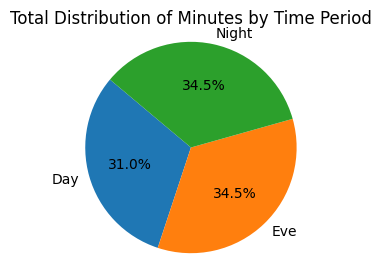

In [54]:
totales_min = {
    'Day': df['total_day_minutes'].sum(),
    'Eve': df['total_eve_minutes'].sum(),
    'Night': df['total_night_minutes'].sum()
}
df_totals_min = pd.DataFrame(list(totales_min.items()), columns=['Period', 'Minutes'])
plt.figure(figsize=(3, 3))
plt.pie(df_totals_min['Minutes'], labels=df_totals_min['Period'], autopct='%1.1f%%', startangle=140)

plt.title('Total Distribution of Minutes by Time Period')

plt.axis('equal')  
plt.show()


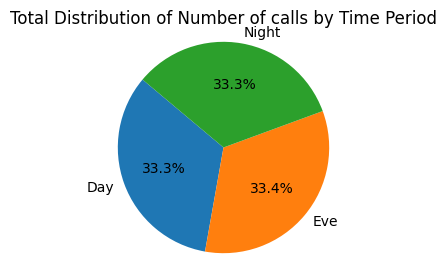

In [55]:
totales_num = {
    'Day': df['total_day_calls'].sum(),
    'Eve': df['total_eve_calls'].sum(),
    'Night': df['total_night_calls'].sum()
}
df_totals_num = pd.DataFrame(list(totales_num.items()), columns=['Period', 'Number'])
plt.figure(figsize=(3,3))
plt.pie(df_totals_num['Number'], labels=df_totals_num['Period'], autopct='%1.1f%%', startangle=140)

plt.title('Total Distribution of Number of calls by Time Period')

plt.axis('equal')  
plt.show()


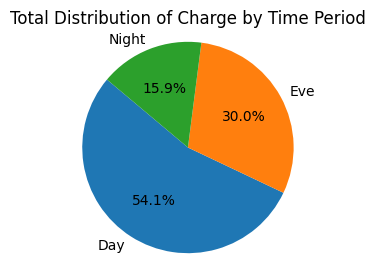

In [56]:
totales_charge = {
    'Day': df['total_day_charge'].sum(),
    'Eve': df['total_eve_charge'].sum(),
    'Night': df['total_night_charge'].sum()
}
df_totals_charge = pd.DataFrame(list(totales_charge.items()), columns=['Period', 'Amount'])
plt.figure(figsize=(3,3))
plt.pie(df_totals_charge['Amount'], labels=df_totals_charge['Period'], autopct='%1.1f%%', startangle=140)

plt.title('Total Distribution of Charge by Time Period')

plt.axis('equal')  
plt.show()

Despite showing a similar distribution in  total minutes and the number of calls across the morning, evening, and night periods, the total charge reveals a distinct pattern. The charge is significantly higher during the morning hours. This discrepancy suggests that while the volume of usage remains consistent throughout the day, the morning period results in greater revenue generatio, perhaps because at the rest of the times of the day there is another type of pricing. Understanding this difference is crucial for optimizing service offerings and pricing strategies during peak usage times

# 4. Feature engineering

In this section, new columns will be created to capture the behavior of the existing features in the dataset, by deriving additional variables from the original ones, the goal is to enhance the model's predictive power and provide deeper insights into the underlying patterns. This process may involve transformations, aggregations, or combinations of existing features, allowing for a more comprehensive representation of the data and potentially improving the model's performance.

1. Total calls duration. It is assumed that the time of international calls will be included within the three other variables.

In [57]:
df['total_minutes'] = (df['total_day_minutes'] +
    df['total_eve_minutes'] +
    df['total_night_minutes']
)

In [58]:
df[df['total_minutes']<df['total_intl_minutes']]

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes


2. Total number of calls. It is assumed that the number of international calls will be included within the three other variables.

In [59]:
df['total_calls'] = (
    df['total_day_calls'] +
    df['total_eve_calls'] +
    df['total_night_calls'] 
)

3. Average call duration. It is assumed that the number of international calls will be included within the three other variables.

In [60]:
df['avg_call_duration'] = df['total_minutes'] / df['total_calls']

4. Ratio International time. It is assumed that the number of international calls will be included within the three other variables.

In [61]:
df['intl_minutes_percentage'] = df['total_intl_minutes'] / df['total_minutes']

5. Ratio of calls to customer service. It is assumed that the number of international calls will be included within the three other variables.

In [62]:
df['customer_service_calls_percentage'] = df['number_customer_service_calls'] / df['total_calls']

6. Total Amount. It is assumed that the number of international calls will be included within the three other variables.

In [63]:
df['total_charge'] = (
    df['total_day_charge'] +
    df['total_eve_charge'] +
    df['total_night_charge'] +
    df['total_intl_charge']
)

In [64]:
added_columns = ['total_minutes', 'total_calls', 'avg_call_duration', 'intl_minutes_percentage', 'customer_service_calls_percentage', 'total_charge']
analyze_statistics(df[added_columns])

Statistical description for each numerical variable in the dataset: 
There are 6 numerical features.


,column_name,count,mean,std,min,25%,50%,75%,99%,max,missing,num_zeros,num_outliers,porc_neg,porc_pos,dtype
0,total_minutes,4250,580.961388,88.823648,275.200000,521.125000,581.400000,640.900000,787.351000,876.900000,0.0,0.000000,29,0.0,100.000000,float64
0,total_calls,4250,299.923294,34.405153,188.000000,277.000000,300.000000,323.000000,379.510000,410.000000,0.0,0.000000,23,0.0,100.000000,int64
0,avg_call_duration,4250,1.962955,0.380245,0.781818,1.699465,1.937085,2.195500,2.986833,3.693644,0.0,0.000000,61,0.0,100.000000,float64
0,intl_minutes_percentage,4250,0.018108,0.005781,0.000000,0.014351,0.017808,0.021506,0.034124,0.044345,0.0,0.517647,105,0.0,99.482353,float64
0,customer_service_calls_percentage,4250,0.005274,0.004521,0.000000,0.002941,0.003717,0.007463,0.020148,0.030612,0.0,20.847059,185,0.0,79.152941,float64
0,total_charge,4250,59.453240,10.345845,22.930000,52.432500,59.495000,66.300000,83.436700,96.150000,0.0,0.000000,34,0.0,100.000000,float64


# 5. Bivariate Analysis

We will replace the values in the international_plan voice_mail_plan and area_code variables, changing "no" with 0 and "yes" with 1. This transformation is essential to facilitate a more effective analysis, as numerical representations are generally more suitable for statistical modeling and machine learning algorithms.

In [65]:
df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,avg_call_duration,intl_minutes_percentage,customer_service_calls_percentage,total_charge
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,...,3,3.70,1,no,611.5,329,1.858663,0.022404,0.003040,59.24
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,...,5,3.29,0,no,527.2,328,1.607317,0.023141,0.000000,62.29
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,...,7,1.78,2,no,558.2,248,2.250806,0.011824,0.008065,66.80
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,...,3,2.73,3,no,501.9,356,1.409831,0.020124,0.008427,52.09
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,...,7,2.03,3,no,779.3,314,2.481847,0.009624,0.009554,78.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,...,6,2.78,0,no,645.8,237,2.724895,0.015949,0.000000,65.13
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,...,6,3.11,3,no,495.3,260,1.905000,0.023218,0.011538,52.88
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,...,7,1.86,1,no,492.9,331,1.489124,0.013999,0.003021,53.10
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,...,5,2.67,2,no,756.2,369,2.049322,0.013092,0.005420,75.09


In [66]:
df['international_plan'] = df['international_plan'].replace({'no': 0, 'yes': 1})
df['voice_mail_plan'] = df['voice_mail_plan'].replace({'no': 0, 'yes': 1})
df['area_code'] = df['area_code'].replace({'area_code_415': 415, 'area_code_408': 408, 'area_code_510': 510})

C:\Users\alfon\AppData\Local\Temp\ipykernel_18020\1078628398.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['international_plan'] = df['international_plan'].replace({'no': 0, 'yes': 1})
C:\Users\alfon\AppData\Local\Temp\ipykernel_18020\1078628398.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['voice_mail_plan'] = df['voice_mail_plan'].replace({'no': 0, 'yes': 1})
C:\Users\alfon\AppData\Local\Temp\ipykernel_18020\1078628398.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

In [67]:
df.international_plan.value_counts()

international_plan
0    3854
1     396
Name: count, dtype: int64

In [68]:
df.churn

0       no
1       no
2       no
3       no
4       no
        ..
4245    no
4246    no
4247    no
4248    no
4249    no
Name: churn, Length: 4250, dtype: object

state is a String Variable!


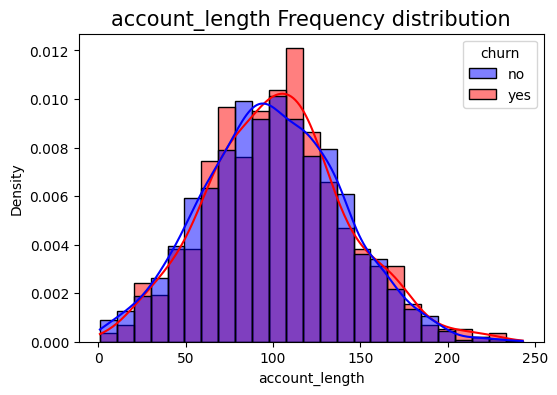

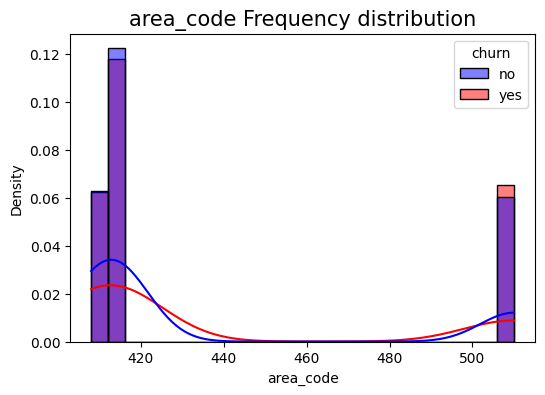

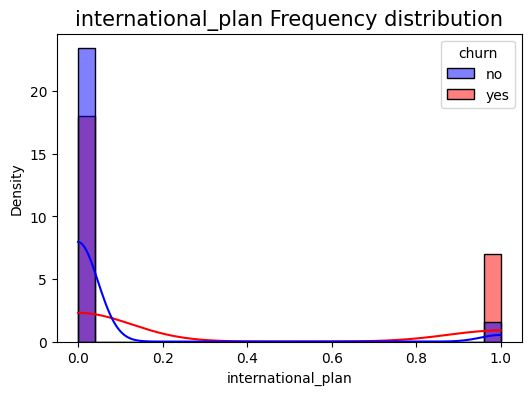

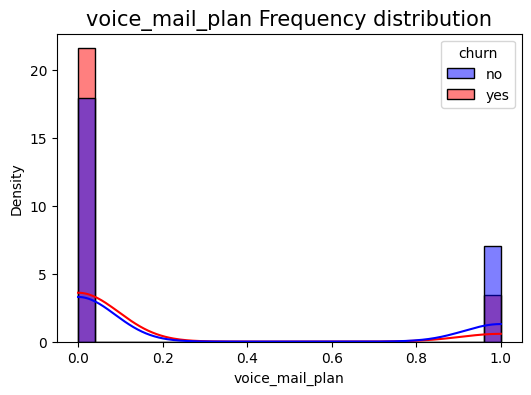

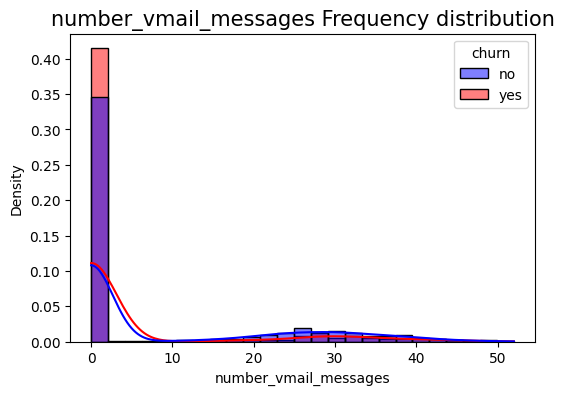

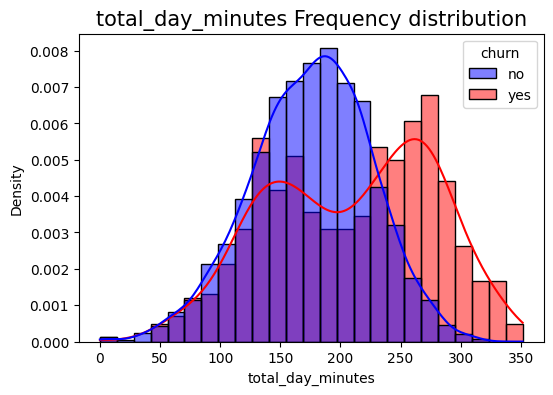

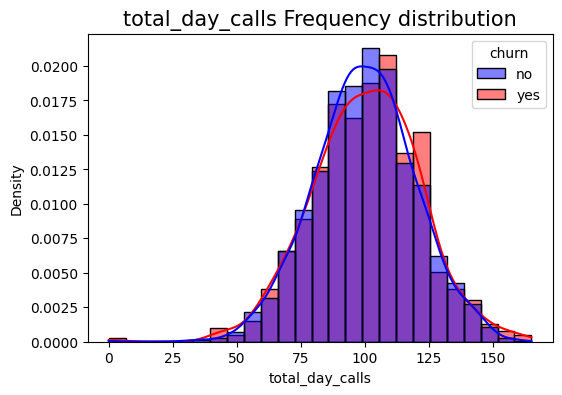

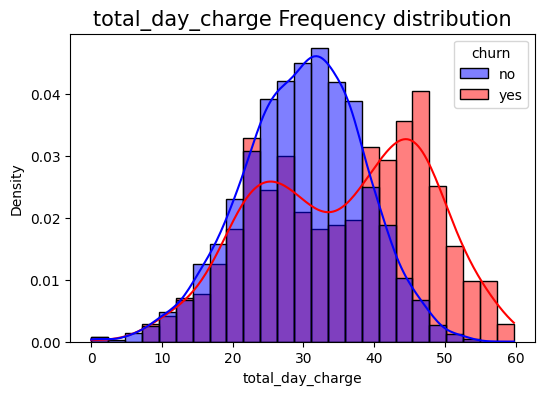

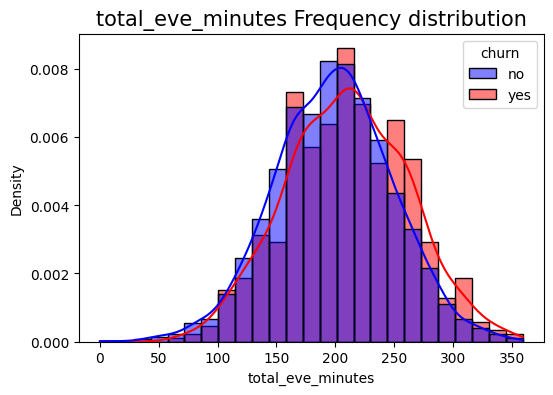

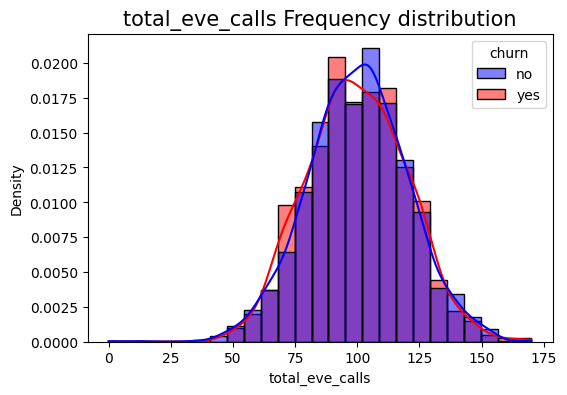

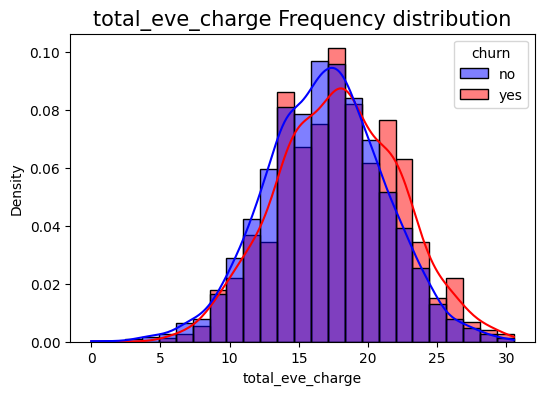

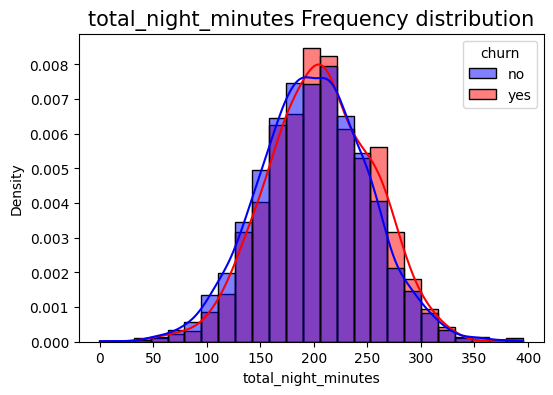

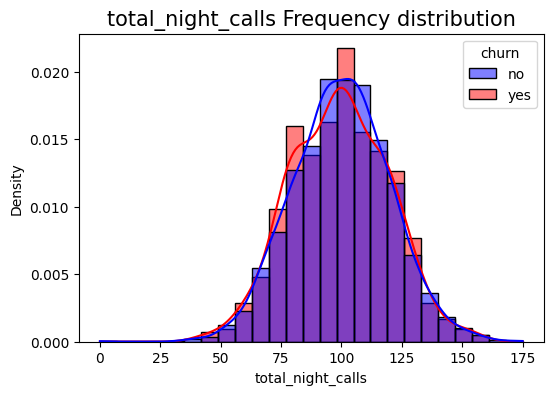

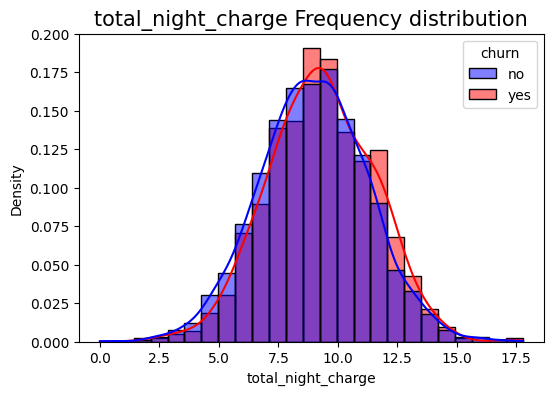

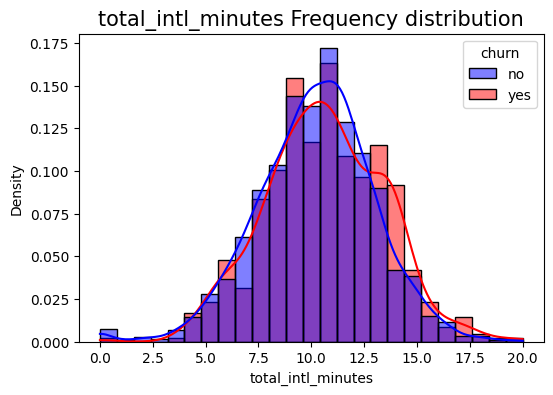

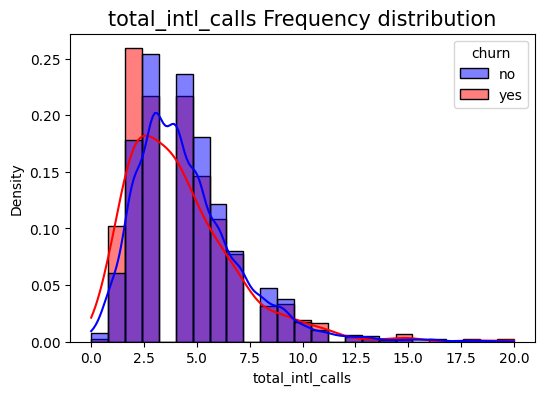

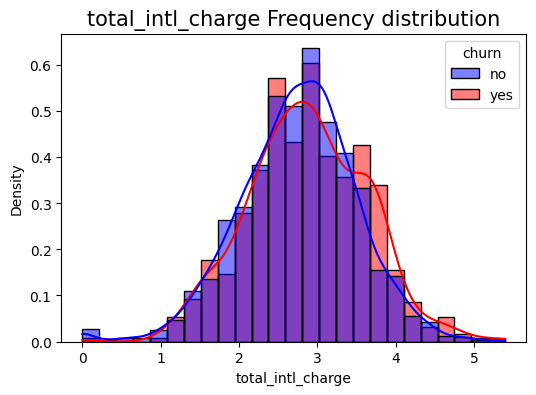

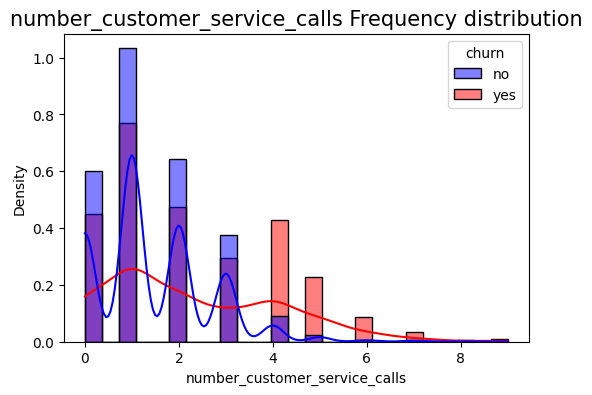

churn is a String Variable!


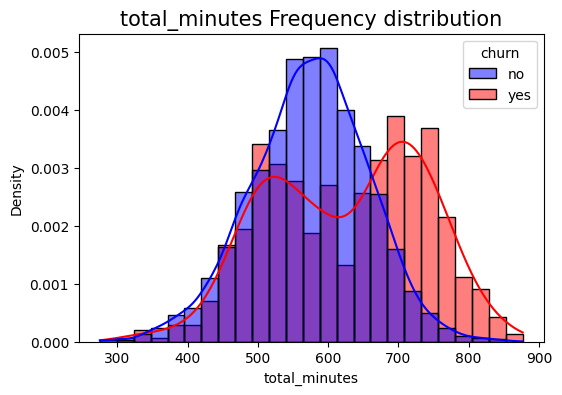

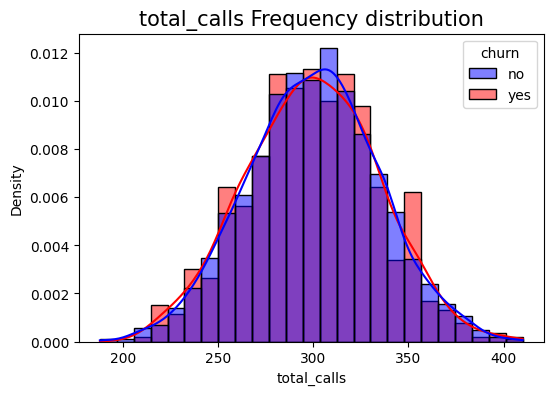

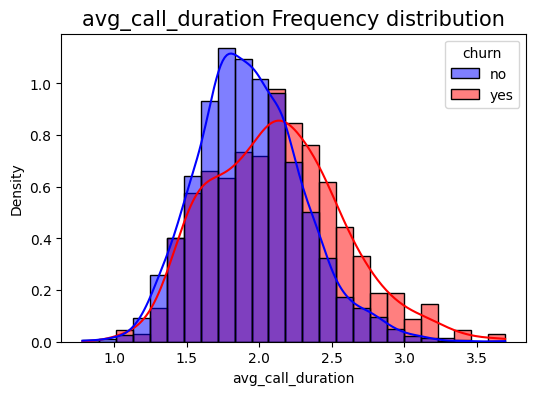

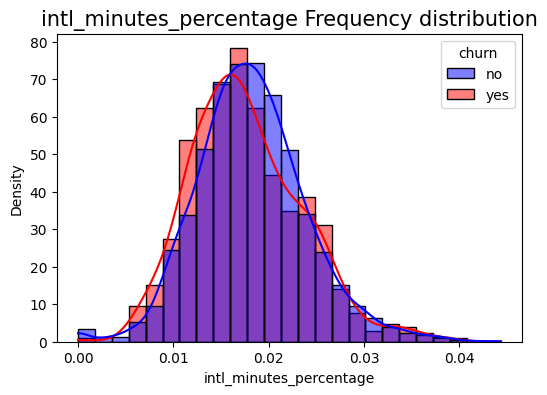

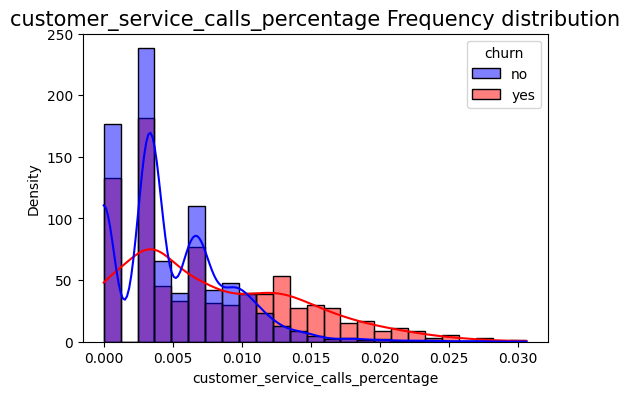

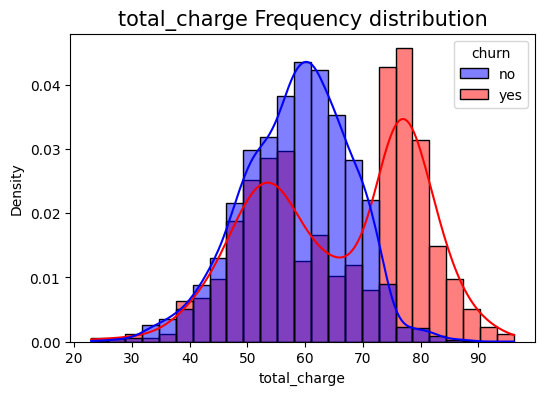

In [69]:
for key in list(df.keys()):
    if df[key].dtypes != 'object' and key != 'churn':
        plt.figure(figsize=(6, 4))  
        g = sns.histplot(x=key,
                         data=df,
                         bins=25,
                         hue="churn",
                         stat="density",
                         common_norm=False,
                         kde=True,
                         palette={'no': 'blue', 'yes': 'red'})
        g.set_title(key + " Frequency distribution", fontsize=15)
        plt.show()
    else:
        print(key + " is a String Variable!")


If we examine the graphs, we can observe that some features visibly exhibit significant discriminative power.


Notice the behavior of the variables total_intl_calls and total_intl_minutes. Despite having a similar business sense, they appear to exhibit opposing behavior concerning churn. It would be beneficial to validate this information with the business team. For now, we will accept it as correct.


For example, the variables that seems most effectively discriminate between the churn population are international_plan, voice_mail_plan, total_day_minutes, total_day_charge, and number_customer_service_calls. These features play a significant role in distinguishing between customers who are likely to churn and those who remain; customers who do not churn tend to have lower values in these variables, indicating that they may spend less time on calls, incur lower charges, and require fewer customer service interactions. 

Four of the variables added during the feature engineering process, (total_minutes, avg_call_duration, customer_service_calls_percentage, and total_charge) also demonstrate strong discriminative power.

This approach allows us to leverage the variable’s inherent distribution and its relationship with the target, highlighting how well it differentiates between different outcomes. Such visual insights can guide us in refining the discretization process and improving the model's performance by focusing on the most influential segments of the data.

# 6. Feature Selection

In this section, we will focus on feature selection to identify the most relevant variables for our predictive model. To ensure the integrity of our analysis, we will first split the dataset into training and test sets. This approach allows us to perform the analysis exclusively on the training set. By carefully selecting the most impactful features, we aim to enhance the predictive power of our model while minimizing complexity and overfitting.

In [70]:
df['churn'] = df['churn'].replace({'no': 0, 'yes': 1})

C:\Users\alfon\AppData\Local\Temp\ipykernel_18020\4113423471.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['churn'] = df['churn'].replace({'no': 0, 'yes': 1})


In [71]:
target_name = 'churn'
X = df.drop(target_name, axis=1)
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [72]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [73]:
y_train.value_counts()[0]/sum(y_train.value_counts())

np.float64(0.8611764705882353)

In [74]:
y_test.value_counts()[0]/sum(y_test.value_counts())

np.float64(0.851764705882353)

Since we are dealing with an imbalanced dataset, it is crucial to ensure that the proportion of the target variable is similar in both the training and test sets. Maintaining this balance helps to create a more reliable evaluation of the model's performance. If the distributions are not comparable, we have the option to stratify the partitioning process, which allows us to preserve the percentage of each class in both subsets

In the first step, we will calculate the Weight of Evidence (WoE) for each categorical variable, as we are effectively working with categorical values represented by numerical values. The WoE transformation helps to quantify the relationship between the categorical features and the target variable, allowing us to capture the predictive power of each category

The categorization will be created within the training set, and this same categorization will be applied to the test set through a mapping process. 

In [75]:
columns_to_encode = ['state','area_code']
target_column = 'churn'
encoder = ce.woe.WOEEncoder(cols=columns_to_encode)
df_encoded = encoder.fit_transform(df_train[columns_to_encode], df_train[target_column])
for col in columns_to_encode:
    df_train[f"{col}_WoE"] = df_encoded[col]

joblib.dump(encoder, r"C:\Users\alfon\OneDrive\Escritorio\CAPGEMINI/woe_enocder.joblib")
encoder = joblib.load(r"C:\Users\alfon\OneDrive\Escritorio\CAPGEMINI/woe_enocder.joblib")
df_encoded_test = encoder.transform(df_test[columns_to_encode], df_test[target_column])
for col in columns_to_encode:
    df_test[f"{col}_WoE"] = df_encoded_test[col]


c:\Users\alfon\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\alfon\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\alfon\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\ordinal.py:198: Futur

We removed the variables that were created prior to the calculation of the WOE, as they are no longer necessary for future analysis. We also deletethe phone number variable, which was deemed random and irrelevant for the model .

In [76]:
df_train = df_train.drop(columns=['state', 'area_code'])
df_test = df_test.drop(columns=['state', 'area_code'])

We will utilize a base XGBoost model to identify the most relevant features for our analysis by focusing on those that demonstrate the highest frequency and gain. Frequency refers to the number of times a feature is selected or predicted as significant by the model, indicating its importance in distinguishing between classes. Gain, on the other hand, measures the improvement in accuracy brought by a feature when it is included in the model; it quantifies the contribution of that feature to the model's performance. By prioritizing features with high frequency and gain, we aim to enhance the interpretability and predictive power of our model, ensuring that we are leveraging the most impactful variables in our analysis.

In [77]:
X_train_2 = df_train.drop(target_name, axis=1)
y_train_2 = df_train[target_name]

X_test_2 = df_test.drop(target_name, axis=1)
y_test_2 = df_test[target_name]

modelo, out =clasification_fs(X_train_2, y_train_2)


Model accuracy for train: 0.98
Confusion Matrix for train:
[[2927    1]
 [  66  406]]
Classification Report for train:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2928
           1       1.00      0.86      0.92       472

    accuracy                           0.98      3400
   macro avg       0.99      0.93      0.96      3400
weighted avg       0.98      0.98      0.98      3400



,Feature,Frequency,Gain,frequency_proportion,gain_proportion
0,account_length,32.0,1.822583,0.028725,0.011787
1,international_plan,92.0,15.278367,0.082585,0.098807
2,voice_mail_plan,31.0,9.502713,0.027828,0.061455
3,number_vmail_messages,8.0,3.872421,0.007181,0.025043
4,total_day_minutes,59.0,8.264826,0.052962,0.053450
5,total_day_calls,24.0,1.621552,0.021544,0.010487
6,total_day_charge,7.0,2.449920,0.006284,0.015844
7,total_eve_minutes,37.0,1.888429,0.033214,0.012213
8,total_eve_calls,32.0,1.734791,0.028725,0.011219
9,total_eve_charge,9.0,1.781903,0.008079,0.011524


We could have also tried other feature selection techniques such us Random Forest, Recursive Feature Elimination (RFE) or PCA

It looks like the model is fitting the training data too well, which raises a red flag for overfitting. This means it might be learning the noise in the training data instead of the actual patterns, potentially leading to poor performance on unseen data. We should keep an eye on this and consider techniques like cross-validation, regularization, or tuning hyperparameters to help mitigate the risk of overfitting.

In [78]:
cv_scores = cross_val_score(modelo, X_train_2, y_train_2, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.2f}")

Cross-validation scores: [0.95735294 0.96617647 0.97647059 0.97058824 0.96617647]
Mean CV accuracy: 0.97



GAIN
- number_customer_service_calls
- total_charge
- international_plan
- voice_mail_plan
- total_day_minutes
- customer_service_calls_percentage
- total_minutes



FRQUENCY
- total_charge
- customer_service_calls_percentage
- total_intl_minutes
- international_plan
- total_intl_calls
- total_day_minutes
- total_minutes


We have selected the top 7 variables based on their frequency and gain. As observed, there is a strong alignment between the most frequently used variables and those with the highest gain, indicating their consistent importance in the model. This selection ensures that we focus on features that contribute significantly to the model's predictive power while maintaining interpretability.

As we can see, most of the variables considered in the bivariate graphical analysis, which showed significant discriminative power, are among the most important features. This highlights the relevance of these variables in our predictive model.

In [79]:
features_pre_selected = ["total_charge",
"customer_service_calls_percentage",
"international_plan",
"total_intl_calls",
"total_day_minutes",
"total_minutes",
"total_intl_minutes",
"number_customer_service_calls",
"voice_mail_plan"]


Next, we will analyze the correlation of the most important variables identified in our feature selection process. It's essential to understand the relationships between these variables, as including highly correlated features can add redundant information and can lead to multicollinearity, which may negatively impact the model's performance and interpretability

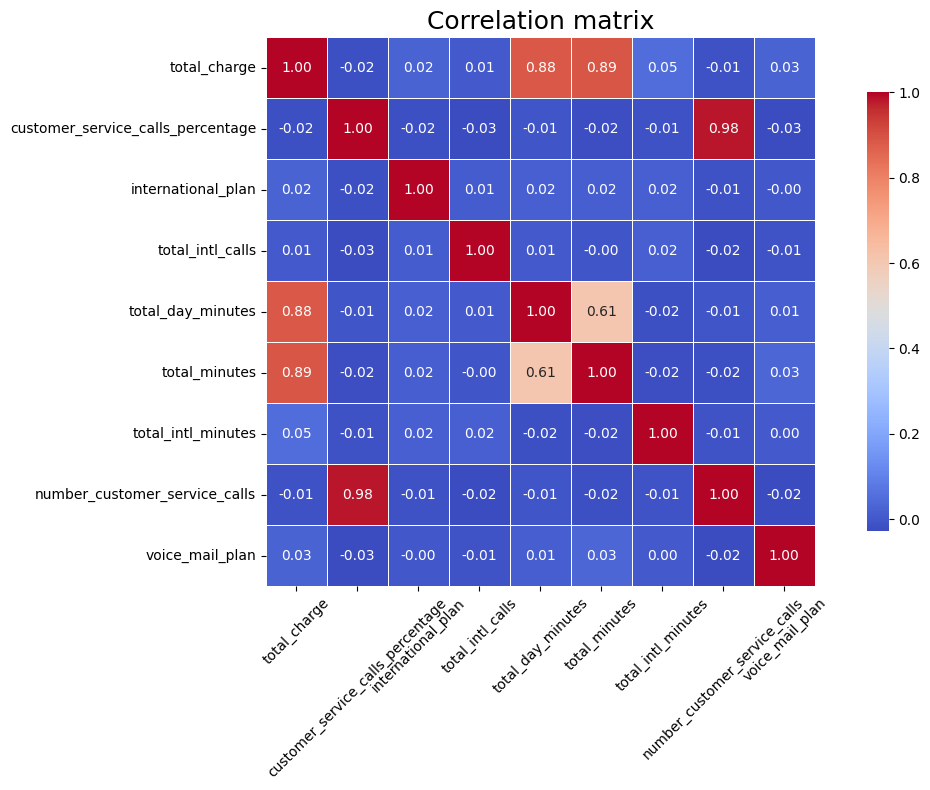

In [80]:
correlation_matrix = X_train_2[features_pre_selected].corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Correlation matrix', fontsize=18)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)   

plt.tight_layout()
plt.show()

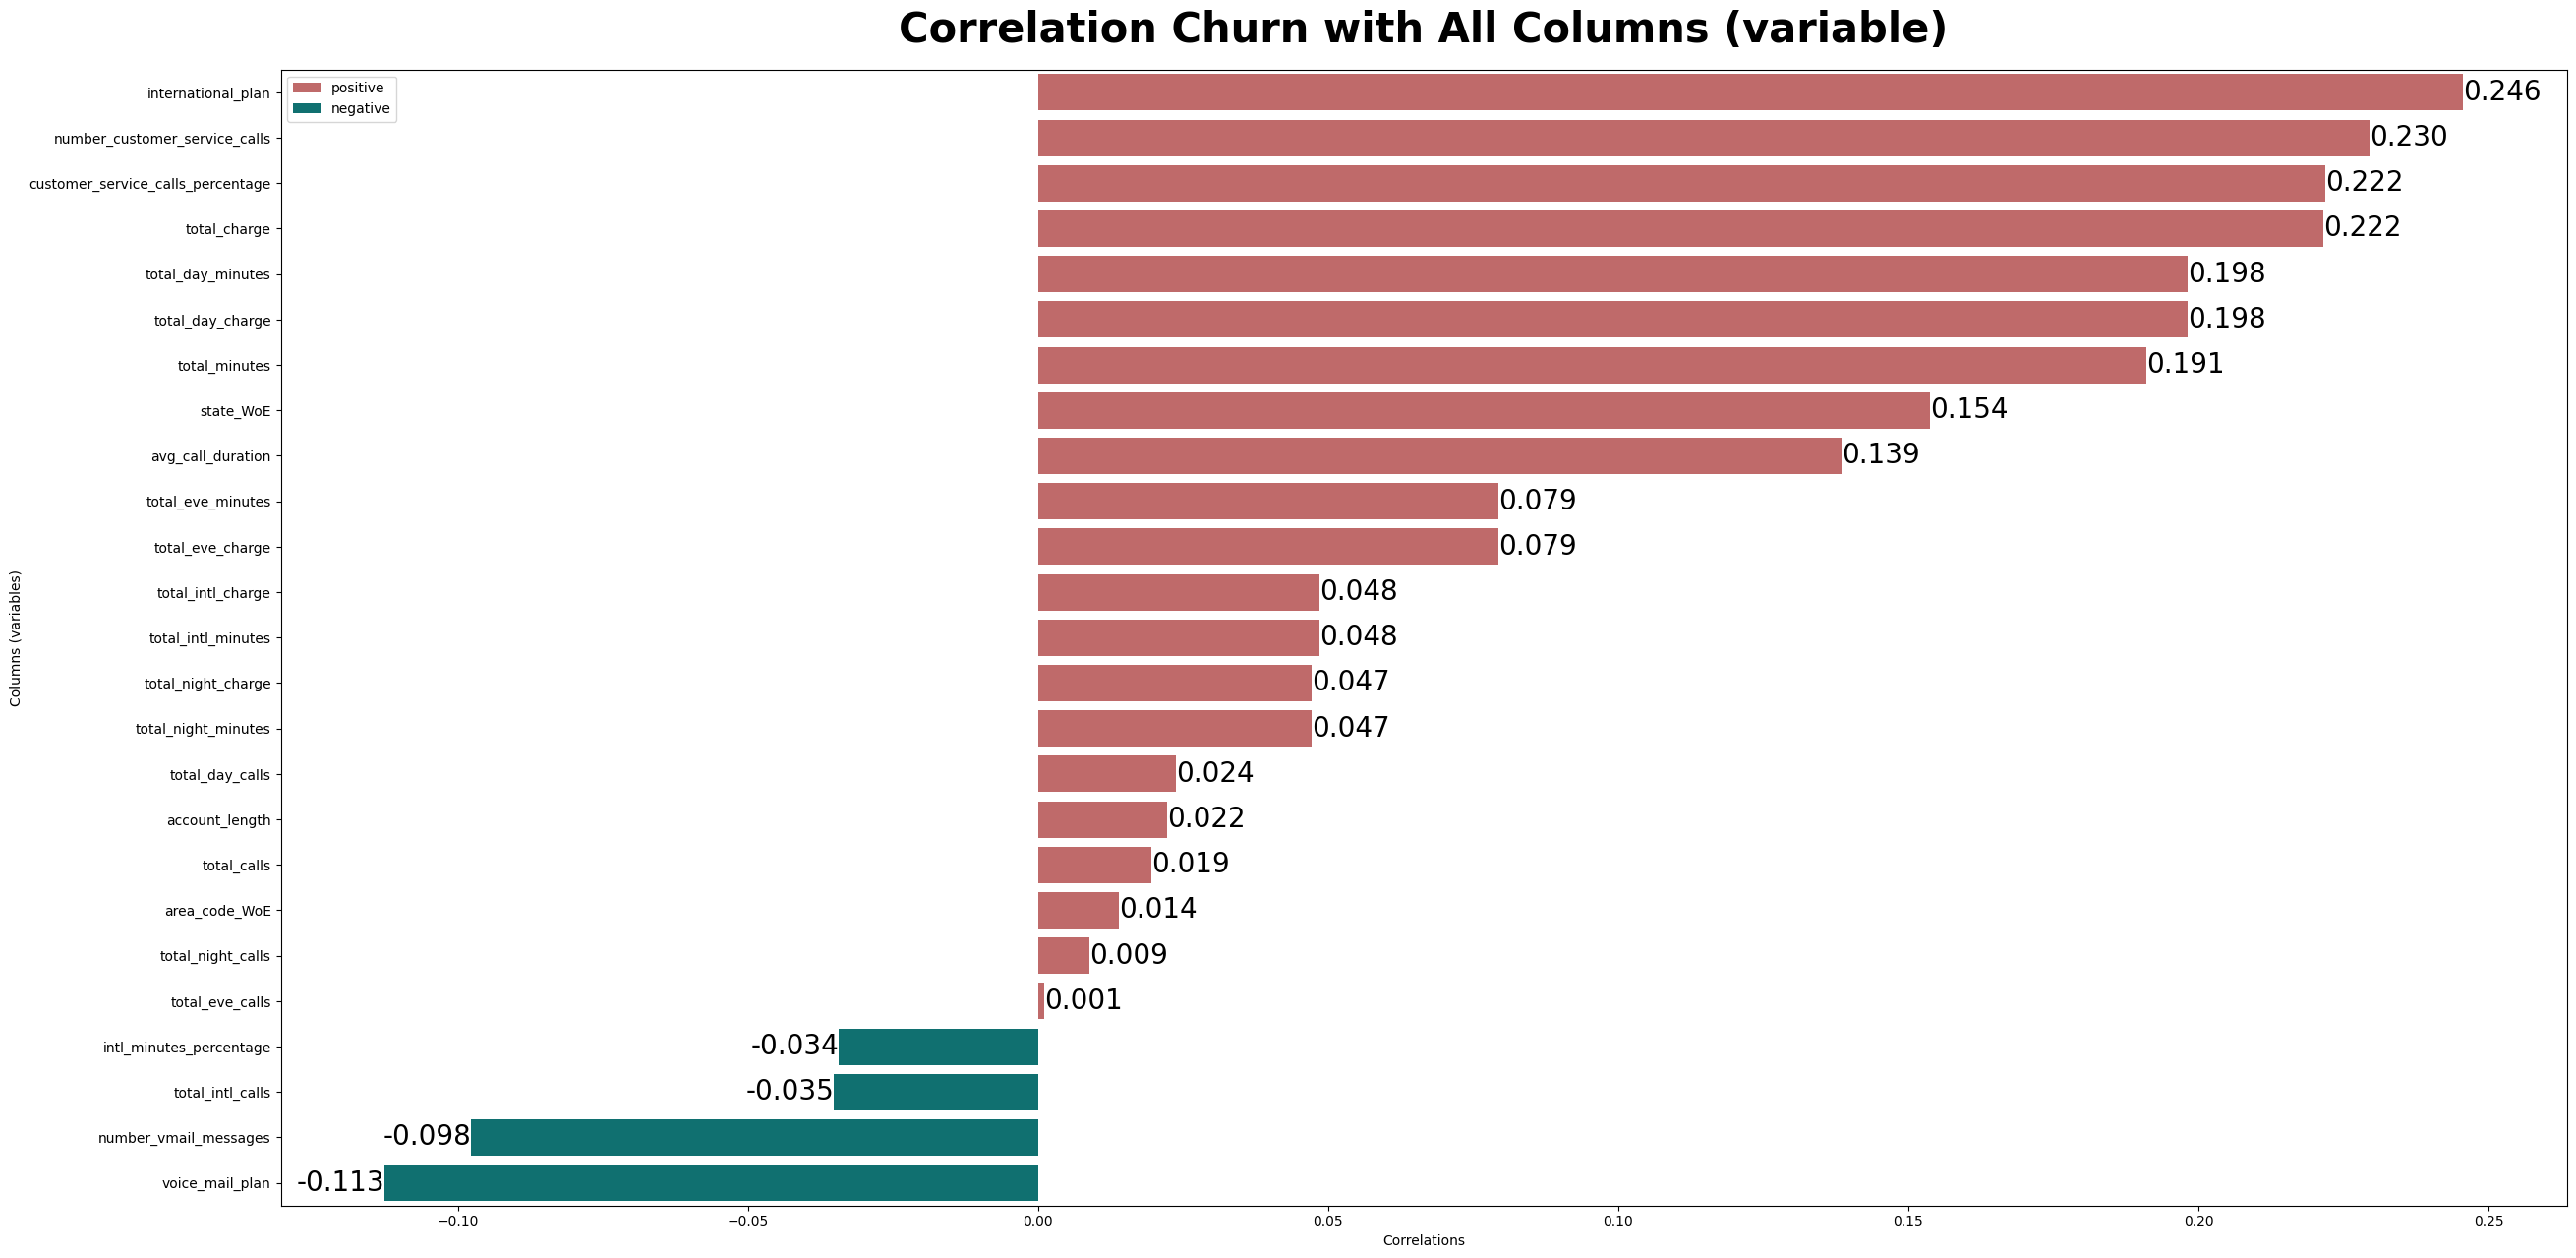

In [81]:
churn_corr = df_train.corr()['churn'].sort_values(ascending=False)[1:].reset_index().rename(columns={'index':'variable', 'churn':'correlation'})
churn_corr['color'] = ['positive' if value > 0 else 'negative' for value in churn_corr['correlation']]
palette = {'positive':'indianred', 'negative':'teal'}

plt.figure(figsize=(30,15))
ax = sns.barplot(data=churn_corr, y='variable', x='correlation', hue='color', palette=palette, dodge=False)
ax.bar_label(ax.containers[0], fontsize=20, fmt='%.3f')
ax.bar_label(ax.containers[1], fontsize=20, fmt='%.3f')
ax.set_xlabel('Correlations')
ax.set_ylabel('Columns (variables)')
ax.set_title('Correlation Churn with All Columns (variable)', fontweight='bold', fontsize=30, pad=20)
plt.legend()
plt.show()

total_charge shows a high correlation with the variables total_day_minutes and total_minutes, which are removed as they have a lower correlation with the target variable.

customer_service_calls_percentage is also removed due to its high correlation with number_customer_service_calls. The decision is made to keep number_customer_service_calls as it provides greater business sense.

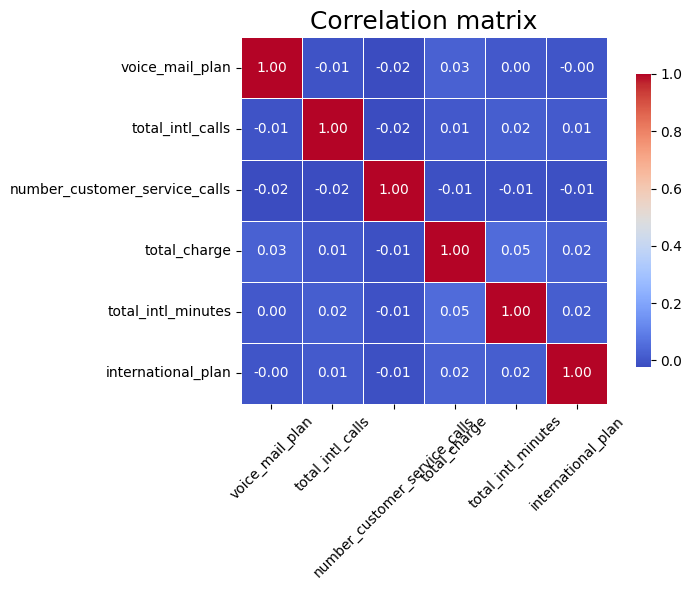

In [82]:
high_corr = ["total_day_minutes", "customer_service_calls_percentage", "total_minutes"]
final_variables = list(set(features_pre_selected)-set(high_corr))
correlation_matrix = X_train_2[final_variables].corr()
plt.figure(figsize=(8,6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Correlation matrix', fontsize=18)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)   

plt.tight_layout()
plt.show()

The final model would include 6 variables, but it’s important to note that achieving the optimal balance often requires several iterations. This involves comparing the trade-off between the number of variables, execution time, and precision. In some cases, it may be beneficial to slightly reduce precision (if it is not a significantly value) in order to incorporate variables that the business stakeholders feel more comfortable with

Although six variables were selected for the model, it would be worthwhile to experiment with a smaller number of features and evaluate the resulting model's precision. By reducing the number of variables, we can assess whether the model maintains its predictive power while potentially simplifying it. To do this, we would need to repeat the methodology used previously, applying feature selection techniques and analyzing the model’s performance with different subsets of variables to ensure that maybe adding more features doesn’timporove its accuracy.

In [83]:
modelo, out =clasification_fs(X_train_2[final_variables], y_train_2)

Model accuracy for train: 0.98
Confusion Matrix for train:
[[2927    1]
 [  67  405]]
Classification Report for train:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2928
           1       1.00      0.86      0.92       472

    accuracy                           0.98      3400
   macro avg       0.99      0.93      0.96      3400
weighted avg       0.98      0.98      0.98      3400



,Feature,Frequency,Gain,frequency_proportion,gain_proportion
0,voice_mail_plan,35.0,9.700863,0.032199,0.176236
1,total_intl_calls,155.0,3.023870,0.142594,0.054935
2,number_customer_service_calls,135.0,14.916337,0.124195,0.270985
3,total_charge,335.0,14.021562,0.308188,0.254730
4,total_intl_minutes,299.0,1.891752,0.275069,0.034367
5,international_plan,128.0,11.490443,0.117755,0.208747


Another option could have been to use a Random Forest model to assess feature importance. From there, we could select 5, 10, or even 15 features and evaluate the model's accuracy with each subset. It’s essential to remember that adding more variables doesn’t always lead to better predictive power. We need to consider the trade-off between model performance and accuracy, as sometimes a simpler model with fewer features can yield more reliable results without sacrificing too much precision.

# 7. Gridsearch 

In [84]:
X_train_3 = X_train_2[final_variables]
y_train_3 = y_train_2
X_test_3 = X_test_2[final_variables]
y_test_3 = y_test_2

In [85]:
def get_best_params_and_estimator(model_des_list, X_train, y_train, X_val, y_val):
  """
  Get best hyperparameters and estimator by using GridSearchCV

  Args:
    model_des_list: Model information containing model name, model object, set of parameters
    X_train: preprocessed training data set
    y_train: training label
    X_val: preprocessed validation data set
    y_val: validation label

  Returns:
    Tuple: Tuple containing best hyper parameters and best estimators
  """
  model = model_des_list['model']
  model_name = model_des_list['name']
  params = model_des_list.get('params', {})

  grid_search = GridSearchCV(model, params, cv=5)
  grid_search.fit(X_train, y_train)
  best_params = grid_search.best_params_
  best_estimator = grid_search.best_estimator_
  return best_params, best_estimator

In [86]:
def get_model_evaluation(model, X, y):
  """
  Get model evaluation report, It helps us to understand how our model is behaving

  Args:
    model: Model on which we have to evaluate model accuracy
    X: Dataset on which we will evaluate model accuracy
    y: Actual label (Truth label values)
  """
  #y_pred = model.predict_proba(X)[:,1]
  y_pred = model.predict(X)
  acc = roc_auc_score(y, y_pred)

  return round(acc, 4)

In [87]:

def get_model_reports(model_des_list, X_train, y_train, X_val, y_val):
  """
  Get the model report based on provided multiple model information

  Args:
    model_des_list: Multiple model information
    X_train, y_train: Training dataset
    X_val, y_val: Validatioin dataset

  Returns:
    List: List of model reports containing, model name, model object, accuracy, hyperparameters
  """
  model_reports = []
  for model_des in model_des_list:
    best_params, best_estimator = get_best_params_and_estimator(model_des, X_train, y_train, X_val, y_val)
    train_accuracy = get_model_evaluation(best_estimator, X_train, y_train)
    val_accuracy = get_model_evaluation(best_estimator, X_val, y_val)

    print(f"Model: {model_des['name']}, train_accuracy: {train_accuracy}, validation accuracy: {val_accuracy}")

    model_report = {
      "name": model_des["name"],
      "model": best_estimator,
      "best_params": best_params,
      "train_accuracy": train_accuracy,
      "val_accuracy": val_accuracy
    }
    model_reports.append(model_report)

  return model_reports




In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression



In [94]:
model_des_list = [
    {
        "name": "RandomForestClassifier",
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    {
        "name": "DecisionTreeClassifier",
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [4, 6, 12],
            "min_samples_leaf": [1, 3, 5]
        }
    },
    {
        "name": "XGBClassifier",
        "model": xgb.XGBClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 6, 9],
            "learning_rate": [0.01, 0.1, 0.2],
            'min_child_weight': [1, 5, 10],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
        }
    },
    {
        "name": "LogisticRegression",
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear"]
        }
    }
]

In [ ]:
model_report = get_model_reports(model_des_list, X_train_3, y_train_3, X_test_3, y_test_3)

Model: RandomForestClassifier, train_accuracy: 0.9333, validation accuracy: 0.9365
Model: DecisionTreeClassifier, train_accuracy: 0.9333, validation accuracy: 0.9298
Model: XGBClassifier, train_accuracy: 0.931, validation accuracy: 0.9365
Model: LogisticRegression, train_accuracy: 0.5425, validation accuracy: 0.5495


We have evaluated the AUC obtained using different models, achieving very similar results with a Decision Tree, Random Forest, and XGBoost. We have decided to select XGBoost as the final model to maintain consistency, as it was the algorithm employed during the feature selection stage. Additionally, other metrics such as F1 Score, Precision, and Recall will be calculated later to further assess and compare the performance of the models, ensuring a comprehensive evaluation.

In [ ]:
xgb_model = [model for model in model_report if model['name'] == 'XGBClassifier'][0]
xgb_model

{'name': 'XGBClassifier',
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'best_params': {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 50,
  'subsample': 0.9},
 'train_accuracy': np.float64(0.931),
 'val_accuracy'

# 8. Final Model

In [95]:
final_model = xgb.XGBClassifier(colsample_bytree= 0.8,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 1,
  n_estimators= 50,
  subsample= 0.9)

In [96]:
final_model.fit(X_train_3, y_train_3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
# Make predictions on the test set using the best model found by GridSearchCV
y_pred_test = final_model.predict(X_test_3)
y_pred_proba_test = final_model.predict_proba(X_test_3)[:, 1]

# Accuracy
accuracy_test = accuracy_score(y_test_3, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.2f}")

# ROC AUC Score
roc_auc_test = roc_auc_score(y_test_3, y_pred_proba_test)
print(f"Test ROC AUC: {roc_auc_test:.2f}")

# Precision, Recall, F1 Score
precision_test = precision_score(y_test_3, y_pred_test)
recall_test = recall_score(y_test_3, y_pred_test)
f1_test = f1_score(y_test_3, y_pred_test)
print(f"Test Precision: {precision_test:.2f}")
print(f"Test Recall: {recall_test:.2f}")
print(f"Test F1 Score: {f1_test:.2f}")

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test_3, y_pred_test)
print("Confusion Matrix for test:")
print(conf_matrix_test)

# Classification Report
class_report_test = classification_report(y_test_3, y_pred_test)
print("Classification Report for test:")
print(class_report_test)



Test Accuracy: 0.98
Test ROC AUC: 0.94
Test Precision: 1.00
Test Recall: 0.87
Test F1 Score: 0.93
Confusion Matrix for test:
[[724   0]
 [ 16 110]]
Classification Report for test:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.87      0.93       126

    accuracy                           0.98       850
   macro avg       0.99      0.94      0.96       850
weighted avg       0.98      0.98      0.98       850



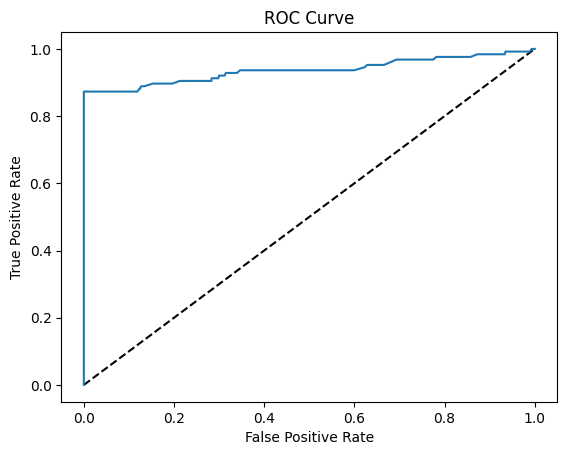

In [99]:
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_proba_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [100]:
importance_frequency = final_model.get_booster().get_score(importance_type='weight')
importance_cover = final_model.get_booster().get_score(importance_type='cover')
importance_gain = final_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
                                'Feature': list(importance_frequency.keys()),
                                'Frequency': list(importance_frequency.values()),
                                'Gain': list(importance_gain.values())
                                })
total_freq = importance_df['Frequency'].sum()
total_gain = importance_df['Gain'].sum()

importance_df['frequency_proportion'] = importance_df['Frequency'] / total_freq
importance_df['gain_proportion'] = importance_df['Gain'] / total_gain
importance_df

,Feature,Frequency,Gain,frequency_proportion,gain_proportion
0,voice_mail_plan,36.0,23.459509,0.118421,0.137708
1,total_intl_calls,33.0,20.116745,0.108553,0.118086
2,number_customer_service_calls,55.0,30.398451,0.180921,0.178440
3,total_charge,72.0,61.567661,0.236842,0.361404
4,total_intl_minutes,60.0,10.271113,0.197368,0.060292
5,international_plan,48.0,24.543549,0.157895,0.144071


The feature with the highest frequency is total_charge, which also contributes significantly to the model’s gain, indicating that this variable plays a key role in identifying churn risk. Voice_mail_plan, while appearing less frequently, has a high gain, suggesting that having a voicemail plan is a strong retention indicator

Number of customer service calls and international plan also have notable contributions to gain, with higher churn risks linked to these variables.

## 8.1. Results

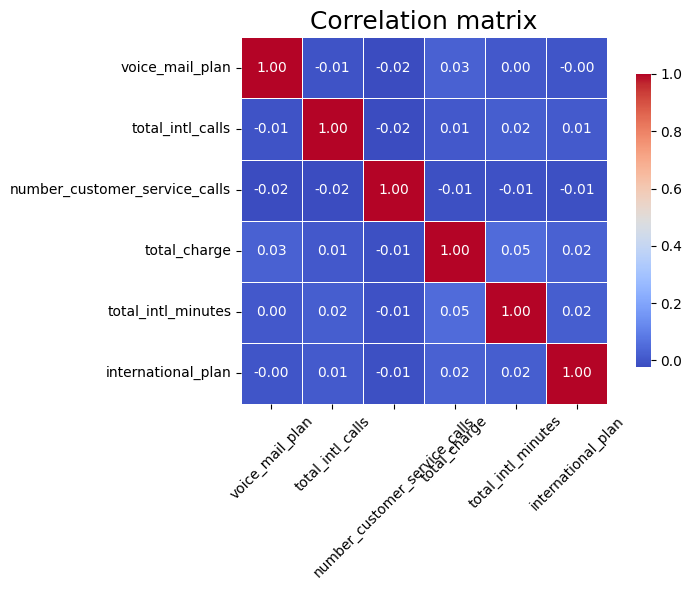

In [101]:
correlation_matrix_spe = X_train_3.corr(method='spearman')
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Correlation matrix', fontsize=18)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)   

plt.tight_layout()
plt.show()

We will verify that there is no nonlinear relationship between the variables by using Spearman's rank correlation. Unlike Pearson's correlation, which measures linear relationships, Spearman's correlation assesses monotonic relationships, making it suitable for detecting nonlinear dependencies. By analyzing the Spearman correlation matrix, we aim to ensure that any potential nonlinear interactions between variables are identified and accounted for, providing a more robust understanding of our data.

In [102]:
y_pred_proba_test_df = pd.DataFrame(y_pred_proba_test, columns=['P_Churn'])

In [103]:
df_test_concat = pd.concat([X_test_3.reset_index(), y_test_3.reset_index(), y_pred_proba_test_df], axis=1)
df_test_union = df_test_concat.copy()

In [104]:
df_test_union['1-p'] = 1 - df_test_union['P_Churn']
df_test_union = df_test_union.sort_values(by='1-p', ascending=False)
percentiles = [0, 0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.90, 1]
thresholds = df_test_union['1-p'].quantile(percentiles).tolist()
df_test_union['grupo'] = pd.cut(df_test_union['1-p'], bins=thresholds, include_lowest=True, labels=[f'Group {i+1}' for i in range(len(thresholds)-1)])
result = df_test_union.groupby('grupo').agg(
    N_Churn=('churn', 'sum'),
    total_obs=('grupo', 'size'),
    min_p_churn =('P_Churn','min')
).reset_index()


total_churn = result['N_Churn'].sum()
total_obs = result['total_obs'].sum()


result['P_churn_bucket'] = result['N_Churn'] / result['total_obs']
result['Obs_acum'] = result['total_obs'].cumsum()
result['Churn_acum'] = result['N_Churn'].cumsum()
result['PRECISION'] = result['Churn_acum'] / result['Obs_acum']
result['Proportion'] = result['Obs_acum'] / total_obs
result['RECALL'] = result['Churn_acum'] / total_churn


result['P_churn_bucket'] = result['P_churn_bucket'] * 100
result['PRECISION'] = result['PRECISION'] * 100
result['Proportion']  = result['Proportion']  * 100
result['RECALL'] = result['RECALL'] * 100


(result)


C:\Users\alfon\AppData\Local\Temp\ipykernel_18020\2567397590.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_test_union.groupby('grupo').agg(


,grupo,N_Churn,total_obs,min_p_churn,P_churn_bucket,Obs_acum,Churn_acum,PRECISION,Proportion,RECALL
0,Group 1,10,10,0.972713,100.000000,10,10,100.000000,1.176471,7.936508
1,Group 2,33,33,0.949759,100.000000,43,43,100.000000,5.058824,34.126984
2,Group 3,42,42,0.823595,100.000000,85,85,100.000000,10.000000,67.460317
3,Group 4,25,44,0.090807,56.818182,129,110,85.271318,15.176471,87.301587
4,Group 5,3,95,0.048796,3.157895,224,113,50.446429,26.352941,89.682540
5,Group 6,5,226,0.029395,2.212389,450,118,26.222222,52.941176,93.650794
6,Group 7,4,219,0.022789,1.826484,669,122,18.236173,78.705882,96.825397
7,Group 8,2,96,0.019511,2.083333,765,124,16.209150,90.000000,98.412698
8,Group 9,2,85,0.011030,2.352941,850,126,14.823529,100.000000,100.000000


It's essential to establish a threshold that the business team feels comfortable with. Lastly, if a decision is made to apply a discount to customers with a high probability of churn, there's a risk of incurring financial losses for the company. By carefully setting this threshold, the business can balance the need for retention with the potential costs associated with offering promotions, ensuring that resources are used effectively and that any incentives provided genuinely lead to improved customer retention without ´risking profitability.

Based on the table above, we could afirm that if we put a thrsehold of aprox 9% we could capture the 87% population that churns seeing only the 15% of the whole population, allowing us to take proactive actions, such as offering promotions or personalized attention, before they decide to leave

Additionally, it’s important to conduct an analysis to ensure that the best customers, even those who currently show a low probability of churn, are well taken care of. While their churn risk may seem minimal now, neglecting to engage with them could lead to future dissatisfaction. Retaining high-value customers through loyalty programs or special offers is essential for long-term profitability and customer retention.

# 9. Explainability

Next, we will use the SHAP values to enhance the overall explainability of the model. SHAP (SHapley Additive exPlanations) provides insights into how each feature contributes to the model's predictions, allowing us to better understand the factors driving decisions and to identify which features are most influential in predicting customer churn. 

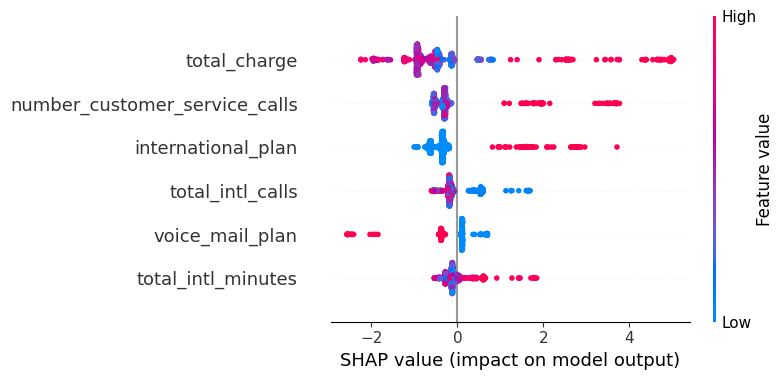

In [105]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test_3)
shap.summary_plot(shap_values, X_test_3)

In [136]:
base_value = shap_values.base_values[0]  # Base value of the model (average log-odds)
shap_values_sample = shap_values.values[100]  # SHAP values for a single observation
features = X_test_3.columns  # List of feature names (from the test DataFrame)

# Get probability contributions
prob_contributions, prob_total = shap_to_probability_contributions(base_value, shap_values_sample, features)

print(f"Probability: {prob_total:.4f}")
for feature, contribution in prob_contributions.items():
    print(f"{feature}: {contribution:.4f}")


Probability: 0.0222
voice_mail_plan: 0.0021
total_intl_calls: -0.0033
number_customer_service_calls: -0.0059
total_charge: -0.0147
total_intl_minutes: -0.0014
international_plan: -0.0028


In [137]:
predicted_proba = final_model.predict_proba(X_test_3)[:, 1][100]  
print(f"Predicted model probability: {predicted_proba:.4f}")
print(f"Calculated with SHAP: {prob_total:.4f}")


Predicted model probability: 0.0222
Calculated with SHAP: 0.0222


# 10. Insights

It's essential to capture churn because retaining existing customers is generally more straightforward and cost-effective than acquiring new ones

For our customer, various promotional strategies can be implemented to enhance retention and engagement.

It would be essential to review the international calling service, as having this service contracted appears to be a significant indicator of churn, possibly due to high prices associated with international calling plans. On the other hand, having voicemail services contracted tends to signal retention among customers. This suggests that offering competitive pricing or attractive packages for international calls could help reduce churn, while promoting the benefits of voicemail services may enhance customer loyalty.

Additionally, a strong customer service presence is crucial, as the number of calls customers make before leaving is a significant indicator of their dissatisfaction. By addressing concerns effectively and promptly, businesses can prevent churn and retain valuable customers. A responsive and empathetic customer support team can make a significant difference in enhancing customer loyalty, knowing how to identify what the customer wants when they contact customer support is important to increase retention.

Another option could involve providing discounts during off-peak hours for specific services, encouraging customers to utilize their plans more effectively while reducing congestion during peak times. These promotions not only improve the overall customer experience but also align with the company's goals of increasing service uptake and customer loyalty.

In [138]:
pwd

'c:\\Users\\alfon\\OneDrive\\Escritorio\\CAPGEMINI'

In [ ]:
'c:\\Users\\alfon\\OneDrive\\Escritorio\\CAPGEMINI'